<a href="https://colab.research.google.com/github/CEMPAplicaciones/MIA/blob/main/Modulo_2/2_3_4_Desbalance_de_clases_SMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
# **Manejo de datos desbalanceados en clasificación: SMOTE y ajuste de pesos**
# **Aplicación en datos de salud con scikit-learn**

# Importación de librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE
from collections import Counter

import rich
from rich.console import Console
console = Console()

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')


## Datos desbalanceados

En el ámbito de los datos médicos, es común encontrarse con **conjuntos de datos desbalanceados**, donde una clase (normalmente la clase positiva, que representa la presencia de una enfermedad) es mucho menos frecuente que la otra.

Este desbalance puede llevar a modelos que:
- Priorizan la predicción de la clase mayoritaria
- Tienen poco poder predictivo para la clase minoritaria (que suele ser la de mayor interés clínico)
- Muestran métricas engañosamente buenas (p.ej., alta precisión)

En este cuaderno, exploraremos dos técnicas principales para manejar este problema:
1. **SMOTE (Synthetic Minority Over-sampling Technique)**: creación de ejemplos sintéticos de la clase minoritaria
2. **Ajuste de pesos de clases**: asignación de mayor importancia a los errores en la clase minoritaria

Utilizaremos datos médicos reales y evaluaremos el rendimiento con métricas apropiadas para datos desbalanceados.

In [49]:
# Cargar conjunto de datos: Breast Cancer Wisconsin
from sklearn.datasets import load_breast_cancer


cancer = load_breast_cancer()
X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y = pd.Series(cancer.target)

print(f"Dimensiones del conjunto de datos: {X.shape[0]} filas, {X.shape[1]} columnas")
print(f"\nColumnas disponibles:\n{', '.join(X.columns[:5])}... (y {len(X.columns)-5} más)")
print(f"\nObjetivo: {cancer.target_names[0]} (0) vs {cancer.target_names[1]} (1)")

# Examinar la distribución de clases original
class_counts = Counter(y)
print(f"\nDistribución de clases original:")
for c, count in class_counts.items():
    class_name = cancer.target_names[c]
    percentage = count / len(y) * 100
    print(f"- Clase {c} ({class_name}): {count} ejemplos ({percentage:.2f}%)")

Dimensiones del conjunto de datos: 569 filas, 30 columnas

Columnas disponibles:
mean radius, mean texture, mean perimeter, mean area, mean smoothness... (y 25 más)

Objetivo: malignant (0) vs benign (1)

Distribución de clases original:
- Clase 0 (malignant): 212 ejemplos (37.26%)
- Clase 1 (benign): 357 ejemplos (62.74%)



## Explorando el desbalance en los datos

Antes de aplicar técnicas para manejar el desbalance, es importante entender la distribución de nuestros datos y visualizar el problema.


<ipython-input-50-db35a5fec71a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=y, palette=['#ff9999', '#66b3ff'])


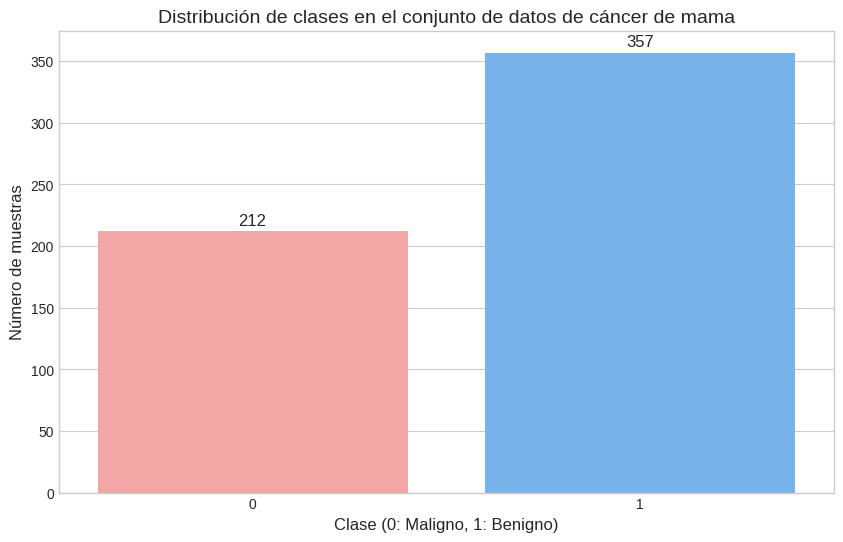

In [50]:
# Visualizar la distribución de clases
plt.figure(figsize=(10, 6))
ax = sns.countplot(x=y, palette=['#ff9999', '#66b3ff'])
plt.title('Distribución de clases en el conjunto de datos de cáncer de mama', fontsize=14)
plt.xlabel('Clase (0: Maligno, 1: Benigno)', fontsize=12)
plt.ylabel('Número de muestras', fontsize=12)

# Añadir etiquetas de texto con los recuentos exactos
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 5, f'{int(height)}',
            ha="center", fontsize=12)

plt.show()

<ipython-input-51-65cbb1f71733>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=y_imbalanced, palette=['#ff9999', '#66b3ff'])


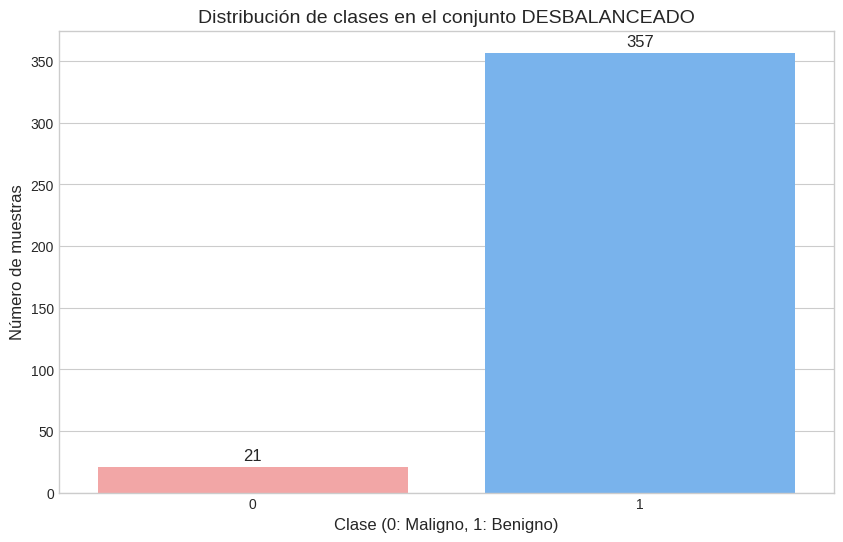

In [51]:
# Creamos un conjunto de datos artificialmente desbalanceado para ilustrar mejor el problema
# (El dataset de cáncer de mama no está muy desbalanceado originalmente)

# Seleccionamos aleatoriamente solo un porcentaje pequeño de la clase 0 (maligno)
# para crear un fuerte desbalance
np.random.seed(42)
malignant_indices = np.where(y == 0)[0]
benign_indices = np.where(y == 1)[0]

# Seleccionamos solo el 10% de los casos malignos
selected_malignant = np.random.choice(malignant_indices, size=int(len(malignant_indices)*0.1), replace=False)
X_imbalanced = pd.concat([X.iloc[selected_malignant], X.iloc[benign_indices]])
y_imbalanced = pd.concat([y.iloc[selected_malignant], y.iloc[benign_indices]])

# Visualizar la distribución desbalanceada
plt.figure(figsize=(10, 6))
ax = sns.countplot(x=y_imbalanced, palette=['#ff9999', '#66b3ff'])
plt.title('Distribución de clases en el conjunto DESBALANCEADO', fontsize=14)
plt.xlabel('Clase (0: Maligno, 1: Benigno)', fontsize=12)
plt.ylabel('Número de muestras', fontsize=12)

# Añadir etiquetas de texto con los recuentos exactos
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 5, f'{int(height)}',
            ha="center", fontsize=12)

plt.show()

In [52]:
# Calcular y mostrar el nuevo ratio de desbalance
class_counts_imbalanced = Counter(y_imbalanced)
print(f"\nDistribución de clases en el conjunto desbalanceado:")
for c, count in class_counts_imbalanced.items():
    class_name = cancer.target_names[c]
    percentage = count / len(y_imbalanced) * 100
    print(f"- Clase {c} ({class_name}): {count} ejemplos ({percentage:.2f}%)")

imbalance_ratio = class_counts_imbalanced[1] / class_counts_imbalanced[0]
print(f"\nRatio de desbalance (mayoritaria:minoritaria): {imbalance_ratio:.2f}:1")


Distribución de clases en el conjunto desbalanceado:
- Clase 0 (malignant): 21 ejemplos (5.56%)
- Clase 1 (benign): 357 ejemplos (94.44%)

Ratio de desbalance (mayoritaria:minoritaria): 17.00:1


## Aplicación de SMOTE (Synthetic Minority Over-sampling Technique)

SMOTE crea ejemplos sintéticos de la clase minoritaria interpolando entre ejemplos existentes cercanos en el espacio de características.

─────────────────────────────────────────────── Aplicación de SMOTE ───────────────────────────────────────────────

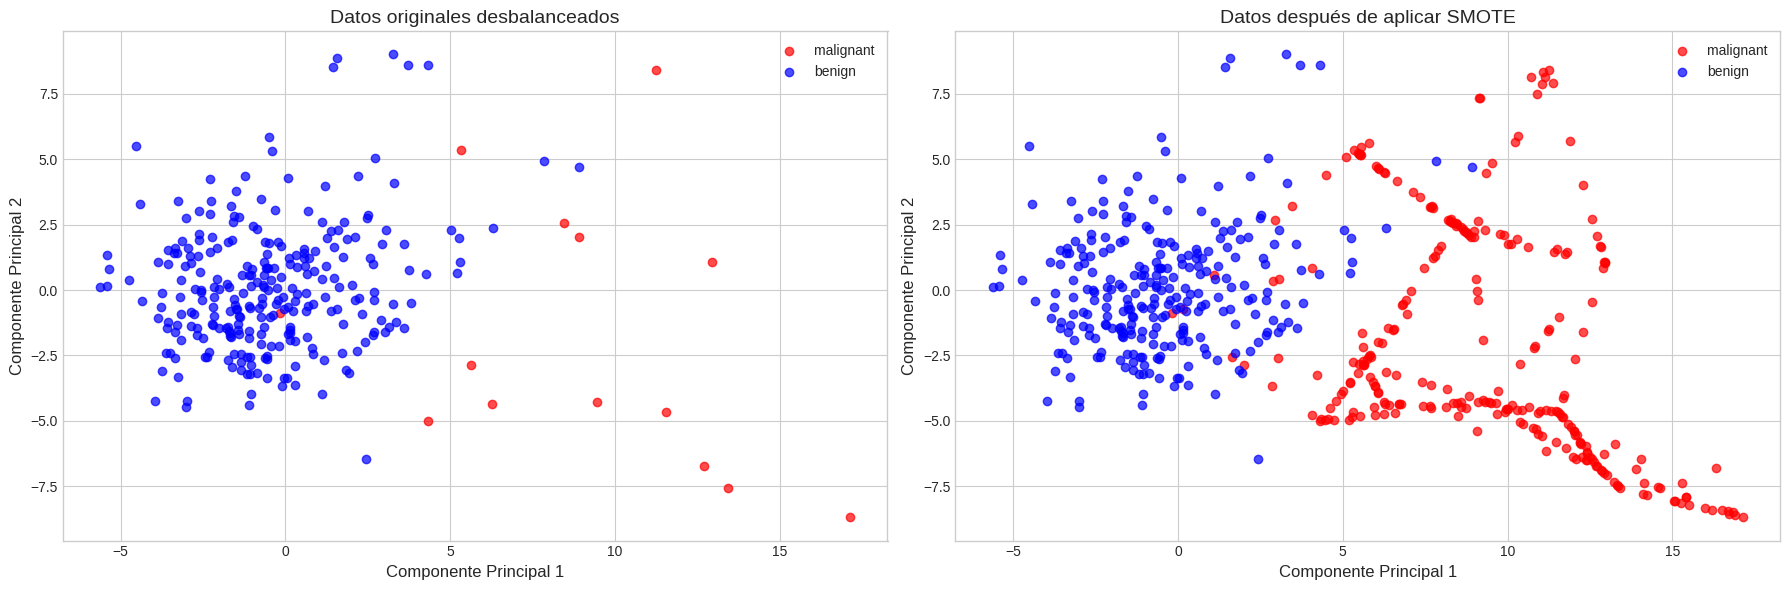

In [53]:
console.rule("Aplicación de SMOTE")

# Visualizar el efecto de SMOTE en un espacio bidimensional para facilitar la comprensión
# Seleccionamos 2 características para visualización
from sklearn.decomposition import PCA

# Reducir a 2 dimensiones para visualización
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train_scaled)

# Visualizar datos originales
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
for label, color in zip([0, 1], ['red', 'blue']):
    mask = y_train == label
    plt.scatter(X_train_2d[mask, 0], X_train_2d[mask, 1], c=color, label=cancer.target_names[label], alpha=0.7)
plt.title('Datos originales desbalanceados', fontsize=14)
plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)
plt.legend()

# Aplicar SMOTE a los datos de entrenamiento 2D para visualización
smote_vis = SMOTE(random_state=42)
X_train_2d_smote, y_train_smote_vis = smote_vis.fit_resample(X_train_2d, y_train)

# Visualizar datos después de SMOTE
plt.subplot(1, 2, 2)
for label, color in zip([0, 1], ['red', 'blue']):
    mask = y_train_smote_vis == label
    plt.scatter(X_train_2d_smote[mask, 0], X_train_2d_smote[mask, 1], c=color, label=cancer.target_names[label], alpha=0.7)
plt.title('Datos después de aplicar SMOTE', fontsize=14)
plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()


In [54]:
# Aplicar SMOTE a los datos de entrenamiento completos
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Mostrar la nueva distribución de clases
smote_class_counts = Counter(y_train_smote)
print("Distribución de clases después de aplicar SMOTE:")
for c, count in smote_class_counts.items():
    class_name = cancer.target_names[c]
    percentage = count / len(y_train_smote) * 100
    print(f"- Clase {c} ({class_name}): {count} ejemplos ({percentage:.2f}%)")

Distribución de clases después de aplicar SMOTE:
- Clase 1 (benign): 269 ejemplos (50.00%)
- Clase 0 (malignant): 269 ejemplos (50.00%)



Informe de clasificación del modelo con SMOTE:
              precision    recall  f1-score   support

   malignant       0.70      1.00      0.82         7
      benign       1.00      0.97      0.98        88

    accuracy                           0.97        95
   macro avg       0.85      0.98      0.90        95
weighted avg       0.98      0.97      0.97        95



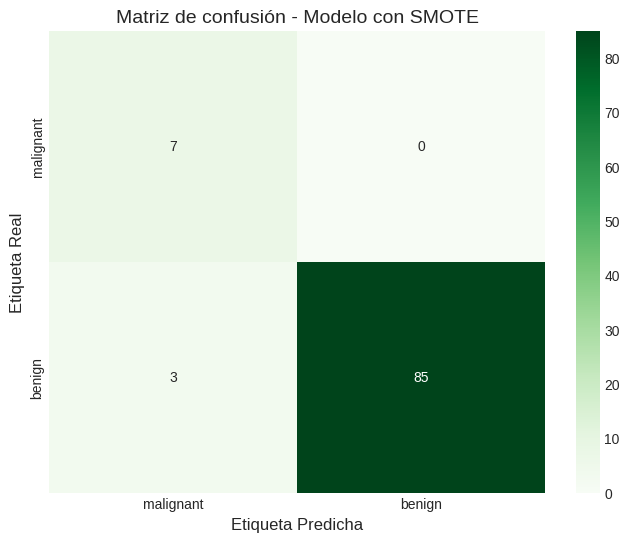

In [55]:
# Entrenar modelo con datos balanceados por SMOTE
smote_model = LogisticRegression(random_state=42)
smote_model.fit(X_train_smote, y_train_smote)

# Evaluación del modelo con SMOTE
y_pred_smote = smote_model.predict(X_test_scaled)
y_prob_smote = smote_model.predict_proba(X_test_scaled)[:, 1]

print("\nInforme de clasificación del modelo con SMOTE:")
print(classification_report(y_test, y_pred_smote, target_names=cancer.target_names))

# Matriz de confusión del modelo con SMOTE
plt.figure(figsize=(8, 6))
cm_smote = confusion_matrix(y_test, y_pred_smote)
sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Greens',
            xticklabels=cancer.target_names,
            yticklabels=cancer.target_names)
plt.title('Matriz de confusión - Modelo con SMOTE', fontsize=14)
plt.ylabel('Etiqueta Real', fontsize=12)
plt.xlabel('Etiqueta Predicha', fontsize=12)
plt.show()

## 4. Aplicación de ajuste de pesos de clases

En lugar de modificar la distribución de los datos, podemos ajustar los pesos de las clases para penalizar más los errores en la clase minoritaria.

───────────────────────────────────────── Aplicación del ajusto de pesos ──────────────────────────────────────────

Pesos calculados por diferentes métodos:
Método 1 (Inverso de la frecuencia): {0: np.float64(10.107142857142858), 1: np.float64(0.5260223048327137)}
Método 2 (Proporción de clases): {0: np.float64(19.214285714285715), 1: 1.0}

Informe de clasificación del modelo con pesos ajustados:
              precision    recall  f1-score   support

   malignant       0.58      1.00      0.74         7
      benign       1.00      0.94      0.97        88

    accuracy                           0.95        95
   macro avg       0.79      0.97      0.85        95
weighted avg       0.97      0.95      0.95        95



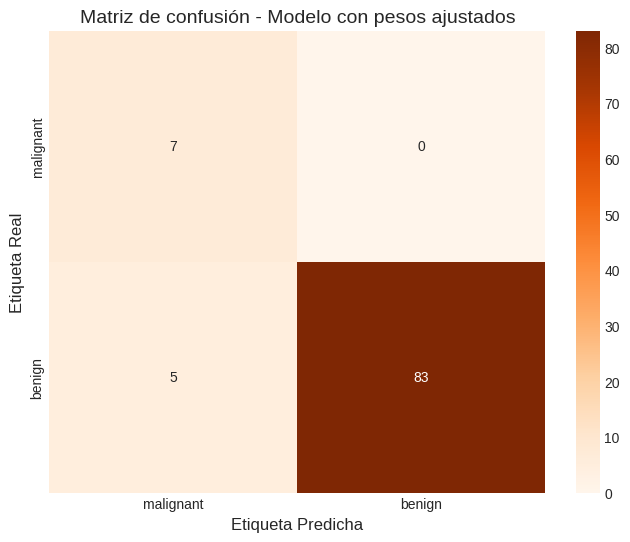

In [56]:
console.rule("Aplicación del ajusto de pesos")

# Calcular los pesos de clase
# Método 1: Inverso de la frecuencia de clase
weight_method1 = {
    0: len(y_train) / (2 * (y_train == 0).sum()),
    1: len(y_train) / (2 * (y_train == 1).sum())
}

# Método 2: Proporción de clases
weight_method2 = {
    0: (y_train == 1).sum() / (y_train == 0).sum(),
    1: 1.0  # La clase mayoritaria mantiene peso 1
}

print("Pesos calculados por diferentes métodos:")
print(f"Método 1 (Inverso de la frecuencia): {weight_method1}")
print(f"Método 2 (Proporción de clases): {weight_method2}")

# Entrenar modelo con pesos de clase
weighted_model = LogisticRegression(class_weight=weight_method2, random_state=42)
weighted_model.fit(X_train_scaled, y_train)

# Evaluación del modelo con pesos
y_pred_weighted = weighted_model.predict(X_test_scaled)
y_prob_weighted = weighted_model.predict_proba(X_test_scaled)[:, 1]

print("\nInforme de clasificación del modelo con pesos ajustados:")
print(classification_report(y_test, y_pred_weighted, target_names=cancer.target_names))

# Matriz de confusión del modelo con pesos
plt.figure(figsize=(8, 6))
cm_weighted = confusion_matrix(y_test, y_pred_weighted)
sns.heatmap(cm_weighted, annot=True, fmt='d', cmap='Oranges',
            xticklabels=cancer.target_names,
            yticklabels=cancer.target_names)
plt.title('Matriz de confusión - Modelo con pesos ajustados', fontsize=14)
plt.ylabel('Etiqueta Real', fontsize=12)
plt.xlabel('Etiqueta Predicha', fontsize=12)
plt.show()

## Conclusiones y recomendaciones prácticas

A partir de nuestro análisis sobre el manejo de datos desbalanceados en problemas de clasificación médica, podemos extraer las siguientes conclusiones y recomendaciones:
"""


1. **Impacto del desbalance**: El modelo base sin ajustes mostró una tendencia clara a favorecer la clase mayoritaria, lo que puede ser peligroso en contextos médicos donde los falsos negativos (no detectar casos positivos) pueden tener graves consecuencias.

2. **Efectividad de SMOTE**:
   - Ventajas: Mejora significativamente el recall de la clase minoritaria sin comprometer excesivamente la precisión.
   - Desventajas: Puede introducir ruido si se generan muestras sintéticas en regiones del espacio de características donde no deberían existir.

3. **Efectividad del ajuste de pesos**:
   - Ventajas: No modifica los datos originales y es fácil de implementar en la mayoría de los algoritmos de scikit-learn.
   - Desventajas: Puede ser menos efectivo que SMOTE en casos de desbalance extremo.

4. **Algoritmos más robustos**:
   - Random Forest mostró mejor rendimiento general frente al desbalance, incluso sin técnicas específicas.
   - SVM con SMOTE o pesos ajustados logró un buen equilibrio entre precisión y recall.

5. **Elección de métricas**:
   - En problemas médicos desbalanceados, es crucial evaluar con métricas como F1-score, ROC AUC o PR AUC en lugar de la exactitud global.
   - Para la clase minoritaria (casos positivos de enfermedad), el recall suele ser más importante que la precisión.

6. **Recomendaciones para datasets médicos desbalanceados**:
   - Comenzar siempre con una exploración exhaustiva del desbalance en los datos.
   - Utilizar validación cruzada estratificada para mantener la proporción de clases en cada partición.
   - Combinar técnicas de sobremuestreo como SMOTE con submuestreo para casos de desbalance extremo.
   - Ajustar el umbral de decisión para favorecer la detección de la clase minoritaria cuando sea clínicamente relevante.
   - Considerar técnicas avanzadas como ADASYN, BorderlineSMOTE o SMOTE-ENN para casos complejos.
   - Si es posible, recopilar más datos de la clase minoritaria.


## Ejemplo con otro conjunto de datos médicos: Diabetes

Para demostrar la aplicabilidad de estas técnicas en otro contexto médico, utilizaremos el conjunto de datos de diabetes de scikit-learn.

────────────────────────── 🔍 CONJUNTO DE DATOS DE DIABETES (CONVERTIDO A CLASIFICACIÓN) ──────────────────────────

Dimensiones: 442 filas, 10 columnas
Características: age, sex, bmi, bp, s1, s2, s3, s4, s5, s6
Objetivo: Nivel de diabetes alto (1) vs bajo (0), usando mediana = 140.50

Distribución de clases en el conjunto de diabetes desbalanceado:
- Clase 1 (Diabetes Alta): 44 ejemplos (16.60%)
- Clase 0 (Diabetes Baja): 221 ejemplos (83.40%)


<ipython-input-57-bfb48218574c>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=y_diabetes_imb, palette=['#aa77ff', '#ff77aa'])


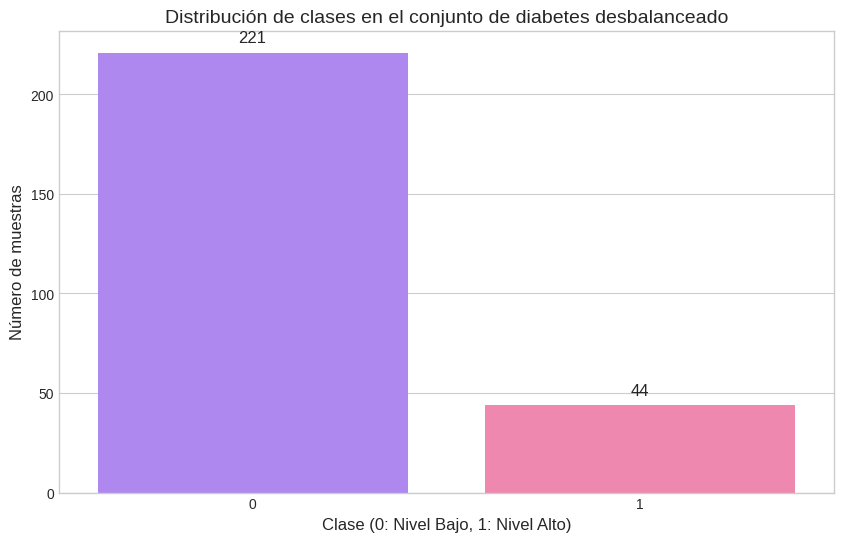

In [57]:
# Cargar dataset de diabetes
from sklearn.datasets import load_diabetes
from sklearn.pipeline import Pipeline

diabetes = load_diabetes()
X_diabetes = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
y_diabetes = pd.Series(diabetes.target)

# Convertir a problema de clasificación (por encima/debajo de la mediana)
diabetes_median = np.median(y_diabetes)
y_diabetes_class = (y_diabetes > diabetes_median).astype(int)

console.rule("🔍 CONJUNTO DE DATOS DE DIABETES (CONVERTIDO A CLASIFICACIÓN)")

print(f"Dimensiones: {X_diabetes.shape[0]} filas, {X_diabetes.shape[1]} columnas")
print(f"Características: {', '.join(X_diabetes.columns)}")
print(f"Objetivo: Nivel de diabetes alto (1) vs bajo (0), usando mediana = {diabetes_median:.2f}")

# Crear desbalance artificial (seleccionar menos casos de clase 1)
np.random.seed(42)
high_indices = np.where(y_diabetes_class == 1)[0]
low_indices = np.where(y_diabetes_class == 0)[0]

# Seleccionar solo el 20% de los casos altos
selected_high = np.random.choice(high_indices, size=int(len(high_indices)*0.2), replace=False)
X_diabetes_imb = pd.concat([X_diabetes.iloc[selected_high], X_diabetes.iloc[low_indices]])
y_diabetes_imb = pd.concat([y_diabetes_class.iloc[selected_high], y_diabetes_class.iloc[low_indices]])

# Mostrar distribución de clases
class_counts_diabetes = Counter(y_diabetes_imb)
print(f"\nDistribución de clases en el conjunto de diabetes desbalanceado:")
for c, count in class_counts_diabetes.items():
    class_name = "Diabetes Alta" if c == 1 else "Diabetes Baja"
    percentage = count / len(y_diabetes_imb) * 100
    print(f"- Clase {c} ({class_name}): {count} ejemplos ({percentage:.2f}%)")

# Visualizar
plt.figure(figsize=(10, 6))
ax = sns.countplot(x=y_diabetes_imb, palette=['#aa77ff', '#ff77aa'])
plt.title('Distribución de clases en el conjunto de diabetes desbalanceado', fontsize=14)
plt.xlabel('Clase (0: Nivel Bajo, 1: Nivel Alto)', fontsize=12)
plt.ylabel('Número de muestras', fontsize=12)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 5, f'{int(height)}',
            ha="center", fontsize=12)

plt.show()


──────────────────────── ⚙️ APLICANDO PIPELINE CON PREPROCESAMIENTO, SMOTE Y RANDOM FOREST ─────────────────────────

Entrenando pipeline con SMOTE...
Entrenando pipeline con pesos ajustados...

Resultados en el conjunto de diabetes:

Pipeline con SMOTE:
               precision    recall  f1-score   support

Diabetes Baja       0.89      0.96      0.92        56
Diabetes Alta       0.67      0.36      0.47        11

     accuracy                           0.87        67
    macro avg       0.78      0.66      0.70        67
 weighted avg       0.85      0.87      0.85        67


Pipeline con pesos ajustados:
               precision    recall  f1-score   support

Diabetes Baja       0.89      1.00      0.94        56
Diabetes Alta       1.00      0.36      0.53        11

     accuracy                           0.90        67
    macro avg       0.94      0.68      0.74        67
 weighted avg       0.91      0.90      0.87        67



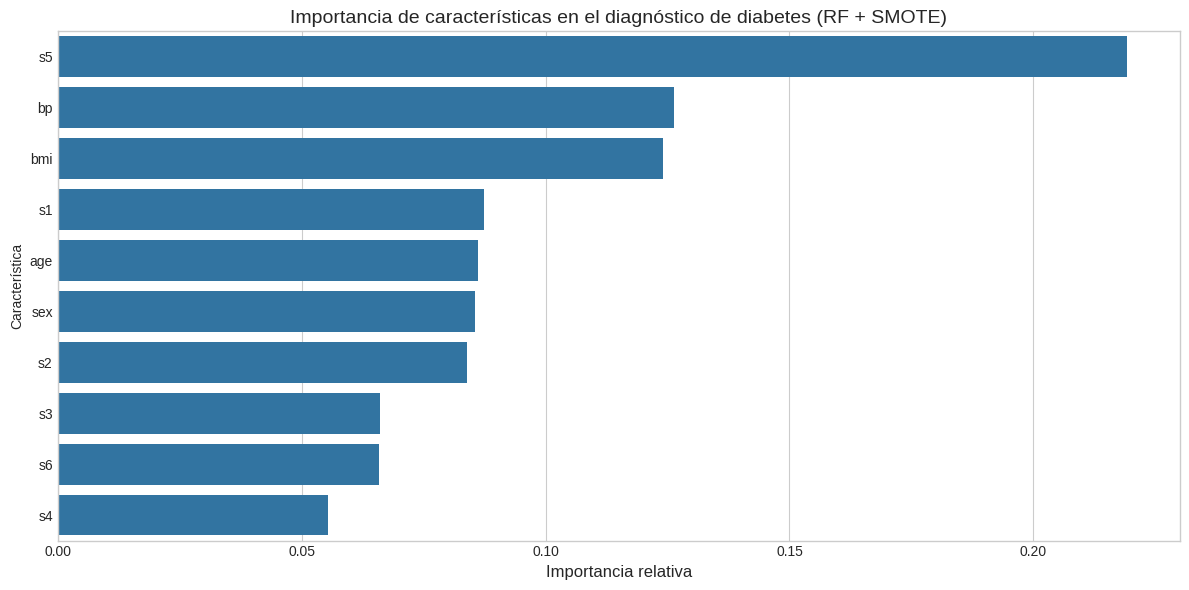

In [58]:
# Aplicar pipeline completo con SMOTE y Random Forest
console.rule("⚙️ APLICANDO PIPELINE CON PREPROCESAMIENTO, SMOTE Y RANDOM FOREST")

# División de datos
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    X_diabetes_imb, y_diabetes_imb, test_size=0.25, random_state=42, stratify=y_diabetes_imb
)

# Crear pipeline con SMOTE integrado
from imblearn.pipeline import Pipeline as ImbPipeline

smote_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

# Pipeline alternativo con ajuste de pesos
weight_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Entrenar y evaluar ambos pipelines
print("Entrenando pipeline con SMOTE...")
smote_pipeline.fit(X_train_d, y_train_d)
y_pred_smote_d = smote_pipeline.predict(X_test_d)

print("Entrenando pipeline con pesos ajustados...")
weight_pipeline.fit(X_train_d, y_train_d)
y_pred_weight_d = weight_pipeline.predict(X_test_d)

# Comparar resultados
print("\nResultados en el conjunto de diabetes:")
print("\nPipeline con SMOTE:")
print(classification_report(y_test_d, y_pred_smote_d,
                           target_names=["Diabetes Baja", "Diabetes Alta"]))

print("\nPipeline con pesos ajustados:")
print(classification_report(y_test_d, y_pred_weight_d,
                           target_names=["Diabetes Baja", "Diabetes Alta"]))

# Visualizar importancia de características en el modelo Random Forest con SMOTE
rf_model = smote_pipeline.named_steps['rf']
feature_importances = pd.DataFrame({
    'Característica': X_diabetes.columns,
    'Importancia': rf_model.feature_importances_
}).sort_values('Importancia', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importancia', y='Característica', data=feature_importances)
plt.title('Importancia de características en el diagnóstico de diabetes (RF + SMOTE)', fontsize=14)
plt.xlabel('Importancia relativa', fontsize=12)
plt.tight_layout()
plt.show()


## Otros métodos avanzados para el manejo de datos desbalanceados

Además de SMOTE y el ajuste de pesos, existen otras técnicas que pueden ser útiles en problemas médicos:


### 1. ADASYN (Adaptive Synthetic Sampling)

Similar a SMOTE, pero genera más ejemplos sintéticos para instancias de la clase minoritaria que son más difíciles de clasificar.

```python
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_scaled, y_train)
```

### 2. SMOTETomek y SMOTEENN (Combinaciones de sobremuestreo y submuestreo)

Aplican SMOTE seguido de técnicas de limpieza para eliminar ejemplos ruidosos o en zonas de solapamiento.

```python
from imblearn.combine import SMOTETomek, SMOTEENN

smote_tomek = SMOTETomek(random_state=42)
X_train_smote_tomek, y_train_smote_tomek = smote_tomek.fit_resample(X_train_scaled, y_train)
```

### 3. BorderlineSMOTE

Genera ejemplos sintéticos solo para instancias de la clase minoritaria cercanas a la frontera de decisión.

```python
from imblearn.over_sampling import BorderlineSMOTE

b_smote = BorderlineSMOTE(random_state=42)
X_train_b_smote, y_train_b_smote = b_smote.fit_resample(X_train_scaled, y_train)
```

### 4. Técnicas de Submuestreo (Undersampling)

Reducen la cantidad de ejemplos de la clase mayoritaria.

```python
from imblearn.under_sampling import RandomUnderSampler, NearMiss

rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_scaled, y_train)
```

### 5. Umbrales de decisión calibrados

Ajuste del umbral de decisión para optimizar métricas específicas.

```python
from sklearn.calibration import CalibratedClassifierCV

# Calibrar el clasificador
calibrated_clf = CalibratedClassifierCV(base_estimator=model, cv=5)
calibrated_clf.fit(X_train_scaled, y_train)

# Encontrar el umbral óptimo para maximizar F1
# [...]
```

### 6. One-class SVM o Isolation Forest

Para casos extremos de desbalance, entrenar solo con la clase minoritaria.

```python
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

one_class = OneClassSVM(gamma='auto')
one_class.fit(X_train_minority)  # Solo ejemplos de la clase minoritaria
```